In [1]:
import sys
sys.path.insert(0, "../../python")

import os
from ionization import ionization
from ionization import adk
from propagation import propagation
from propagation import laser
from lens import profile
from lens import bessel
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy import integrate
from numpy.fft import fft, ifft, fft2, ifft2, fftfreq, fftshift
from scipy.special import jn
from ht import intht

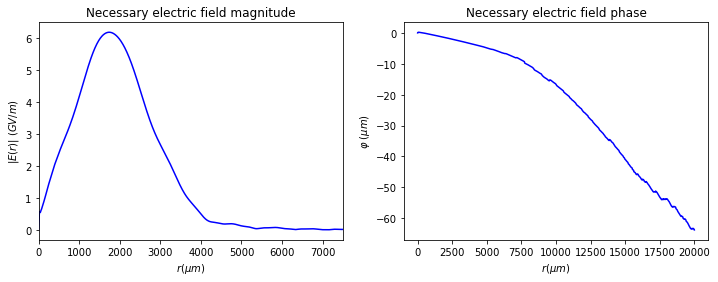

In [2]:
# Create the desired intensity profile
ion = {'atom' : ionization.H2,
       'tau' : 50,
       'type' : 'gaussian'}
z0 = 1.5e6
zf = 50e6
dz = 1e6
sigmaIn = 15e4
sigmaOut = 15e4
N = 50000
z, I = profile.smoothed_gaussian_ramps(z0, dz, sigmaIn, sigmaOut, ion, N, zf)

# As before Fourier expand along the optical axis
R = 0.3e3
order = 2
params = {'N' : 5000,
          'M' : 5000,
          'R' : R,
          'lam' : 0.8,
          'rmax' : 20e3
         }
Ez = ionization.field_from_intensity(I)
lam = params['lam']
k = 2*np.pi/lam
kz, S = bessel.spectrum_from_axis(Ez, z)
kr0 = 2.4048 / params['R']
kz0 = np.sqrt(k**2 - kr0**2)
kz = kz + kz0
S = S / kz
kr, S = bessel.kr_from_kz(kz, lam, S)
# Inverse Hankel transform
krn = np.linspace(0, np.amax(kr), params['N'])
Sn = interp1d(kr, S, fill_value=(S[-1], 0.0), bounds_error=False)
Sn = Sn(krn)
rm = np.linspace(0, params['rmax'], params['M'])
E = intht.ihtn(Sn, krn, rm, order)
E = E*8.15e6

k = 2*np.pi/params['lam']
phi = np.unwrap(np.angle(E))

plt.figure(figsize=(12, 4))

plt.subplot(121)
plt.plot(rm, abs(E), 'b-')
plt.xlabel(r'$r (\mu m)$')
plt.ylabel(r'$|E(r)|$ $(GV/m)$')
plt.title(r'Necessary electric field magnitude')
plt.xlim([0, 7500])

plt.subplot(122)
plt.plot(rm, phi/k, 'b-')
plt.xlabel(r'$r (\mu m)$')
plt.ylabel(r'$\varphi$ ($\mu m$)')
plt.title(r'Necessary electric field phase')
plt.show()

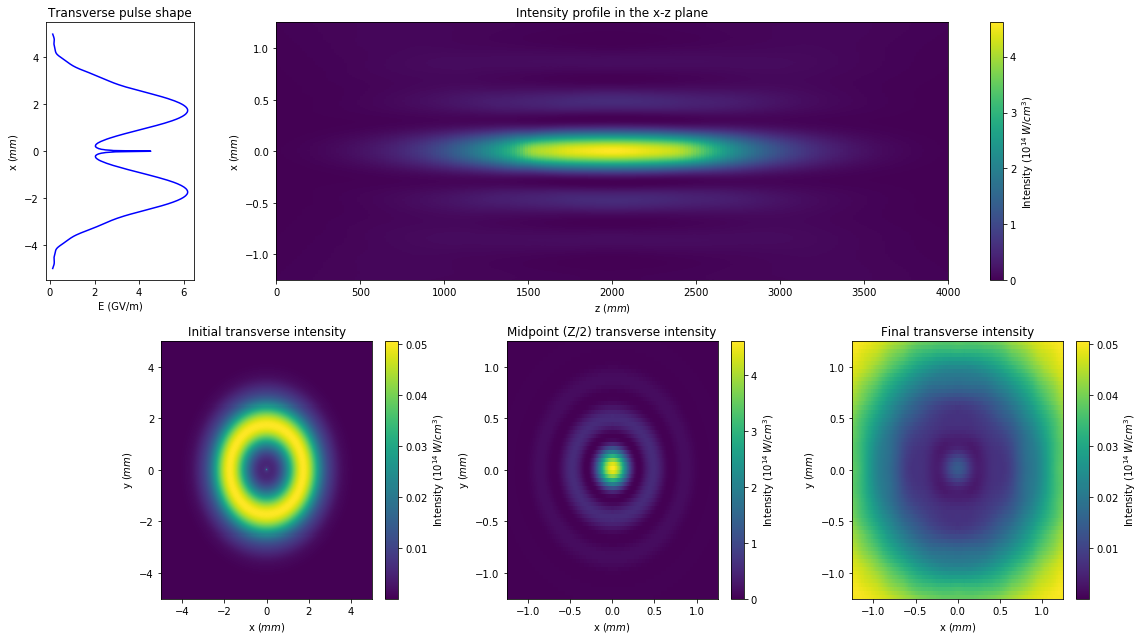

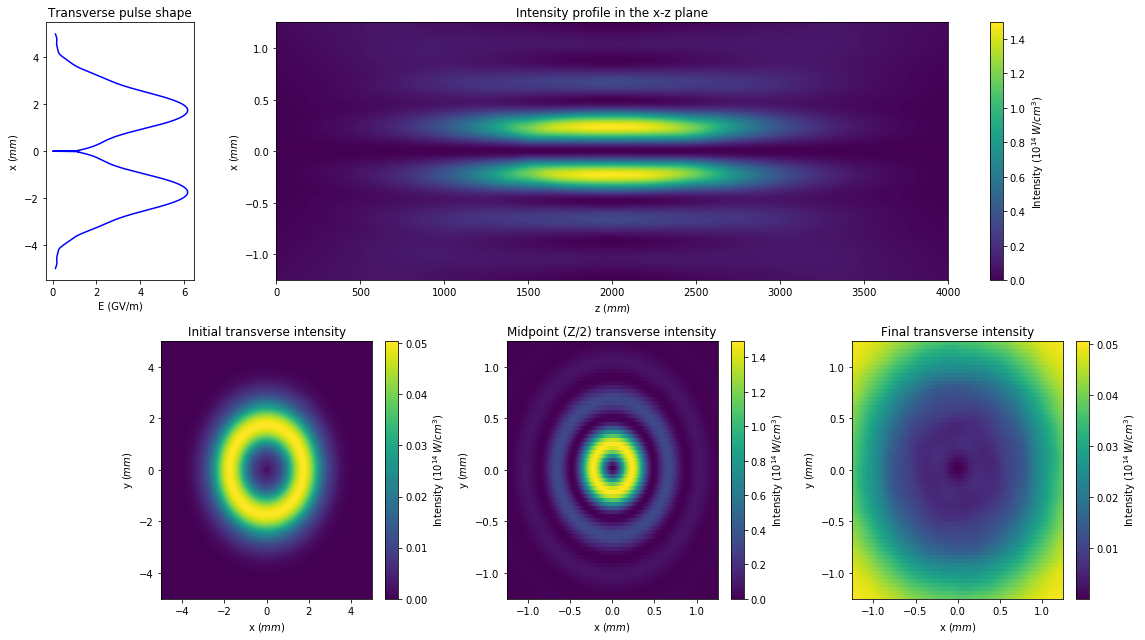

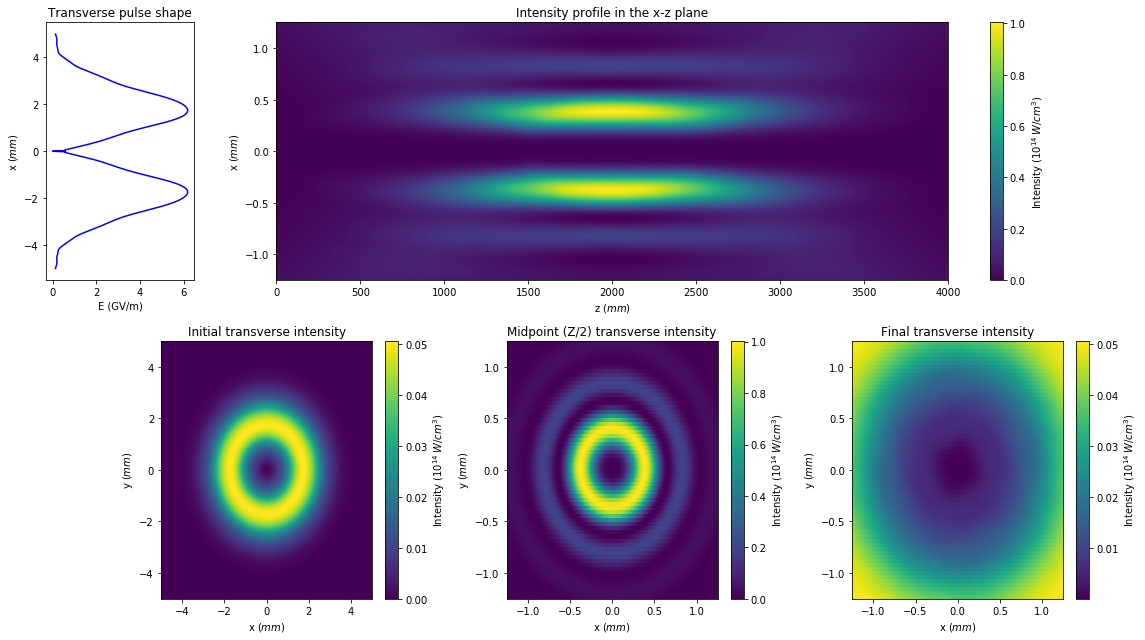

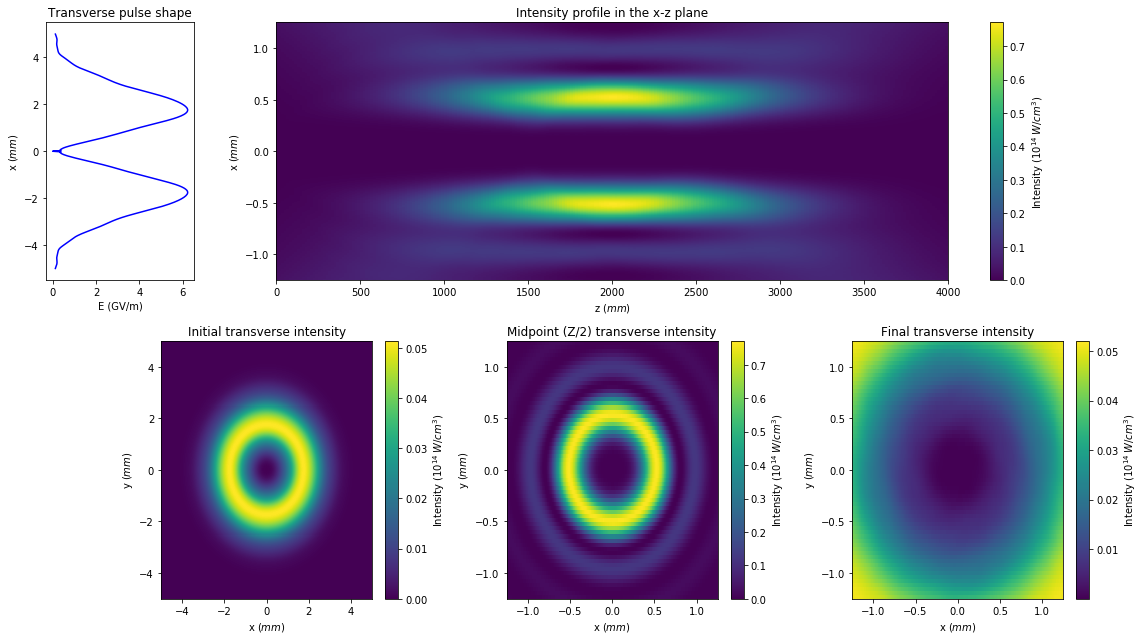

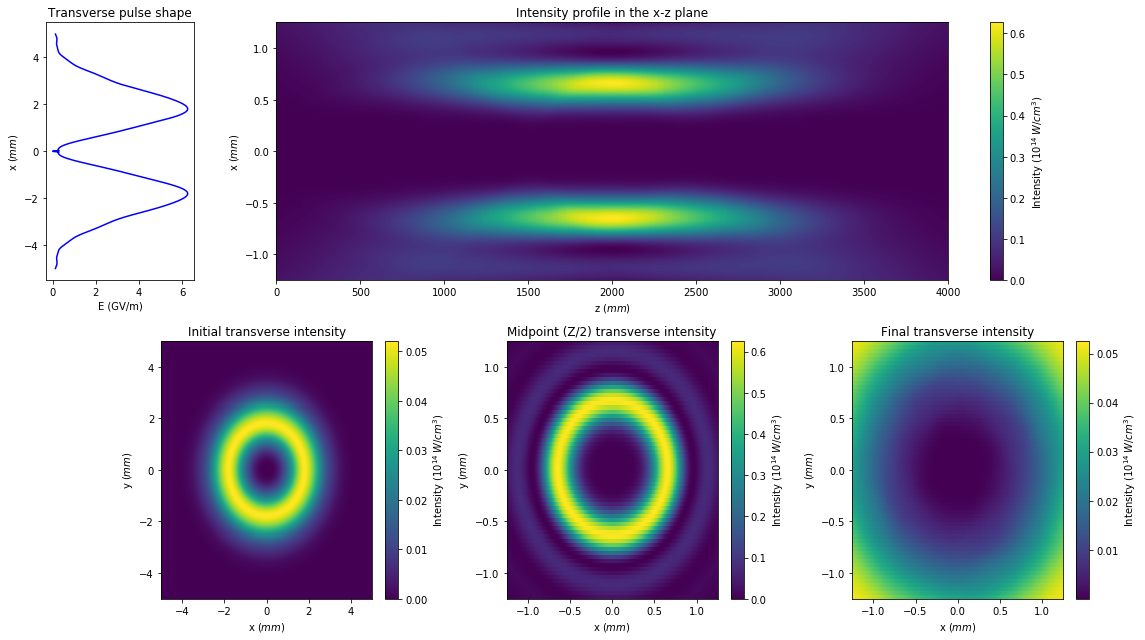

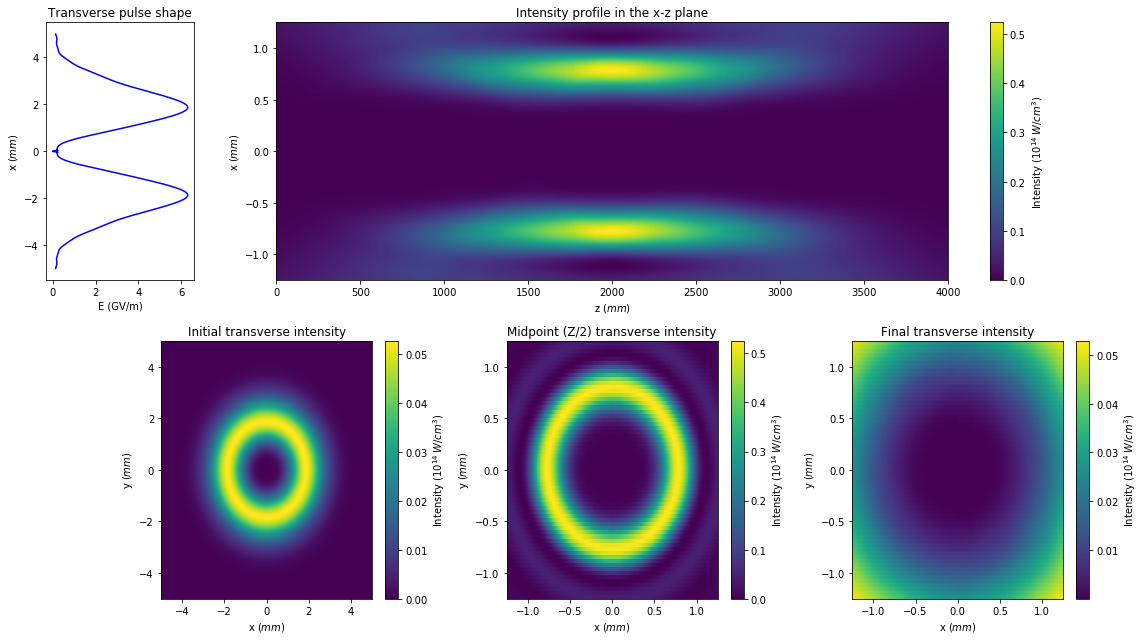

In [3]:
orderArr = [0 ,1, 2, 3, 4, 5]
orderName = ['Zero', 'First', 'Second', 'Third', 'Fourth', 'Fifth']
for i in range(0, 6):
    R = 0.3e3
    order = orderArr[i]
    params = {'N' : 5000,
          'M' : 5000,
          'R' : R,
          'lam' : 0.8,
          'rmax' : 20e3
         }
    Ez = ionization.field_from_intensity(I)
    lam = params['lam']
    k = 2*np.pi/lam
    kz, S = bessel.spectrum_from_axis(Ez, z)
    kr0 = 2.4048 / params['R']
    kz0 = np.sqrt(k**2 - kr0**2)
    kz = kz + kz0
    S = S / kz
    kr, S = bessel.kr_from_kz(kz, lam, S)
    # Inverse Hankel transform
    krn = np.linspace(0, np.amax(kr), params['N'])
    Sn = interp1d(kr, S, fill_value=(S[-1], 0.0), bounds_error=False)
    Sn = Sn(krn)
    rm = np.linspace(0, params['rmax'], params['M'])
    E = intht.ihtn(Sn, krn, rm, order)
    E = E*8.15e6

    Efield = interp1d(rm, E)
    def Efunc(x, y):
        r = np.sqrt(x**2 + y**2)
        Efield = params['Efield']
        phi = np.zeros(np.shape(r))
        phi[int(params['Nx']/2), int(params['Ny']/2):] = np.pi/2
        phi[int(params['Nx']/2), :int(params['Ny']/2)] = -np.pi/2
        sel = np.array(x > 0)
        xp = x[sel]
        xp = np.reshape(xp, (np.size(xp), 1))
        phi[int(params['Nx']/2+1):, :] = np.arctan(y/xp)
        sel = np.array(x < 0)
        xn = x[sel]
        xn = np.reshape(xn, (np.size(xn), 1))
        phi[:int(params['Nx']/2), :] = np.arctan(y/xn) + np.pi
        E0 = Efield(r) * np.exp(1j*order*phi)
        return E0

    # Setup the parameters
    params = {'Nx' : 2**11,
          'Ny' : 2**8,
          'Nz' : 2**8,
          'Nt' : 2**6,
          'X' : 10e3,
          'Y' : 10e3,
          'Z' : 4e6,
          'n0' : 0.5,
          'E0' : 1.0,
          'lam' : lam,
          'n' : 1.0,
          'Efield' : Efield
          }

    path = '/media/robert/Data_Storage/Data/Optics/nBessel/'
    directory = orderName[i]+'_Order_Bessel'
    params['path'] = path + directory+'/'
    # Create the directory if it doesn't exist
    if not os.path.exists(params['path']):
        os.makedirs(params['path'])
    # Simulate free space propagation
    propagation.laser_prop(params, Efunc)
    propagation.laser_prop_plot(params['path'])

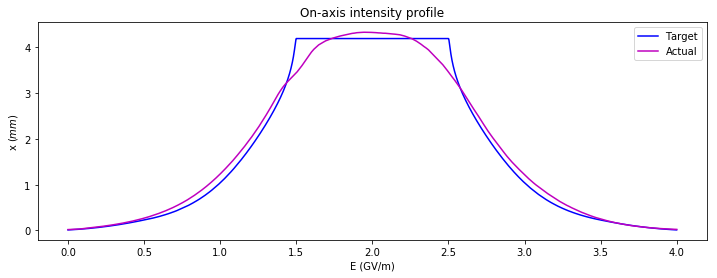

In [4]:
Eplot = np.load('/media/robert/Data_Storage/Data/Optics/nBessel/Second_Order_Bessel/electricField.npy')
Nx = params['Nx']
Ny = params['Ny']
Nz = params['Nz']
Z = params['Z']

zplot = np.linspace(0, Z, Nz)
#From zeros of the Bessel function
peakInd = int(params['Nx']*R*5.1356/(2*2.4048*params['X']))
Eplot = ionization.intensity_from_field(abs(Eplot[:, int(Nx/2)+peakInd, int(Ny/2)]))

plt.figure(figsize={12, 4})
plt.plot(z[0:4000]/1e6, I[0:4000], 'b-', zplot/1e6, Eplot*5, 'm-')
plt.xlabel(r'E (GV/m)')
plt.ylabel(r'x ($mm$)')
plt.title('On-axis intensity profile')
plt.legend(['Target', 'Actual'])
plt.show()
del Eplot

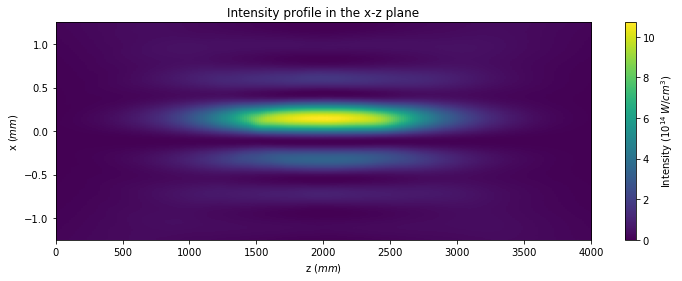

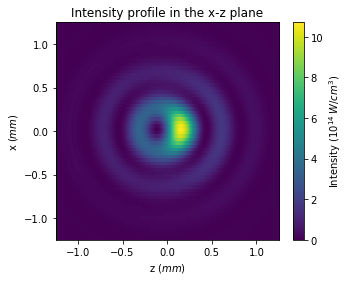

In [5]:
E1Order = np.load('/media/robert/Data_Storage/Data/Optics/nBessel/First_Order_Bessel/electricField.npy')
E0Order = np.load('/media/robert/Data_Storage/Data/Optics/nBessel/Zero_Order_Bessel/electricField.npy')
Etot = np.sqrt(3)*E1Order + E0Order

X = params['X']
Y = params['Y']

plt.figure(figsize=(12,4))
plt.imshow(propagation.prep_data(Etot[:, :, int(Ny/2)]),
               aspect='auto',
               extent=[0, Z/1e3, -X/2e3, X/2e3])
cb = plt.colorbar()
cb.set_label(r'Intensity ($10^{14}\,W/cm^3$)')
plt.set_cmap('viridis')
plt.xlabel(r'z ($mm$)')
plt.ylabel(r'x ($mm$)')
plt.title('Intensity profile in the x-z plane')
plt.xlim([0, Z/1e3])
plt.ylim([-X/8e3, X/8e3])
plt.show()

plt.figure(figsize=(5,4))
plt.imshow(propagation.prep_data(Etot[int(Nz/2), :, :]),
               aspect='auto',
               extent=[-X/2e3, X/2e3, -Y/2e3, Y/2e3,])
cb = plt.colorbar()
cb.set_label(r'Intensity ($10^{14}\,W/cm^3$)')
plt.set_cmap('viridis')
plt.xlabel(r'z ($mm$)')
plt.ylabel(r'x ($mm$)')
plt.title('Intensity profile in the x-z plane')
plt.ylim([-Y/8e3, Y/8e3])
plt.xlim([-X/8e3, X/8e3])
plt.show()

del E1Order
del E0Order
del Etot

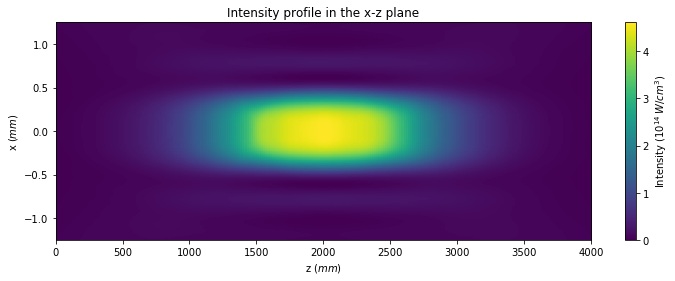

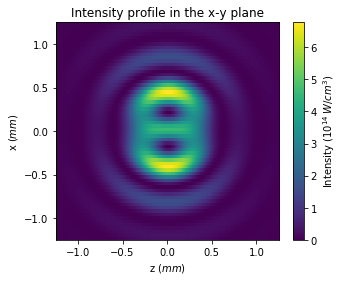

In [6]:
E2Order = np.load('/media/robert/Data_Storage/Data/Optics/nBessel/Second_Order_Bessel/electricField.npy')
E0Order = np.load('/media/robert/Data_Storage/Data/Optics/nBessel/Zero_Order_Bessel/electricField.npy')
Etot = np.sqrt(4)*E2Order + E0Order

X = params['X']
Y = params['Y']

plt.figure(figsize=(12,4))
plt.imshow(propagation.prep_data(Etot[:, :, int(Ny/2)]),
               aspect='auto',
               extent=[0, Z/1e3, -X/2e3, X/2e3])
cb = plt.colorbar()
cb.set_label(r'Intensity ($10^{14}\,W/cm^3$)')
plt.set_cmap('viridis')
plt.xlabel(r'z ($mm$)')
plt.ylabel(r'x ($mm$)')
plt.title('Intensity profile in the x-z plane')
plt.xlim([0, Z/1e3])
plt.ylim([-X/8e3, X/8e3])
plt.show()

plt.figure(figsize=(5,4))
plt.imshow(propagation.prep_data(Etot[int(Nz/2), :, :]),
               aspect='auto',
               extent=[-X/2e3, X/2e3, -Y/2e3, Y/2e3,])
cb = plt.colorbar()
cb.set_label(r'Intensity ($10^{14}\,W/cm^3$)')
plt.set_cmap('viridis')
plt.xlabel(r'z ($mm$)')
plt.ylabel(r'x ($mm$)')
plt.title('Intensity profile in the x-y plane')
plt.ylim([-Y/8e3, Y/8e3])
plt.xlim([-X/8e3, X/8e3])
plt.show()

del E2Order
del E0Order
del Etot

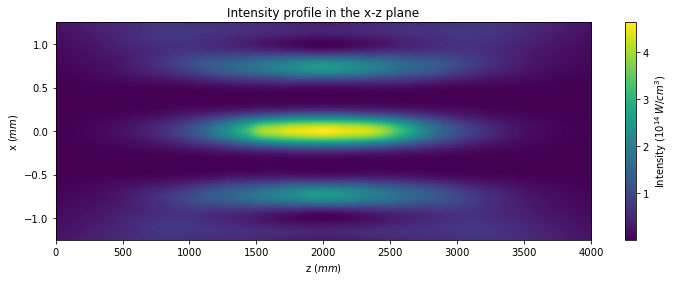

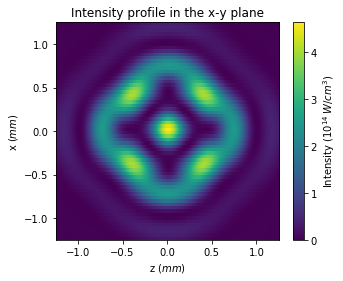

In [7]:
E4Order = np.load('/media/robert/Data_Storage/Data/Optics/nBessel/Fourth_Order_Bessel/electricField.npy')
E0Order = np.load('/media/robert/Data_Storage/Data/Optics/nBessel/Zero_Order_Bessel/electricField.npy')
Etot = np.sqrt(4)*E4Order + E0Order

X = params['X']
Y = params['Y']

plt.figure(figsize=(12,4))
plt.imshow(propagation.prep_data(Etot[:, :, int(Ny/2)]),
               aspect='auto',
               extent=[0, Z/1e3, -X/2e3, X/2e3])
cb = plt.colorbar()
cb.set_label(r'Intensity ($10^{14}\,W/cm^3$)')
plt.set_cmap('viridis')
plt.xlabel(r'z ($mm$)')
plt.ylabel(r'x ($mm$)')
plt.title('Intensity profile in the x-z plane')
plt.xlim([0, Z/1e3])
plt.ylim([-X/8e3, X/8e3])
plt.show()

plt.figure(figsize=(5,4))
plt.imshow(propagation.prep_data(Etot[int(Nz/2), :, :]),
               aspect='auto',
               extent=[-X/2e3, X/2e3, -Y/2e3, Y/2e3,])
cb = plt.colorbar()
cb.set_label(r'Intensity ($10^{14}\,W/cm^3$)')
plt.set_cmap('viridis')
plt.xlabel(r'z ($mm$)')
plt.ylabel(r'x ($mm$)')
plt.title('Intensity profile in the x-y plane')
plt.ylim([-Y/8e3, Y/8e3])
plt.xlim([-X/8e3, X/8e3])
plt.show()

del E4Order
del E0Order
del Etot

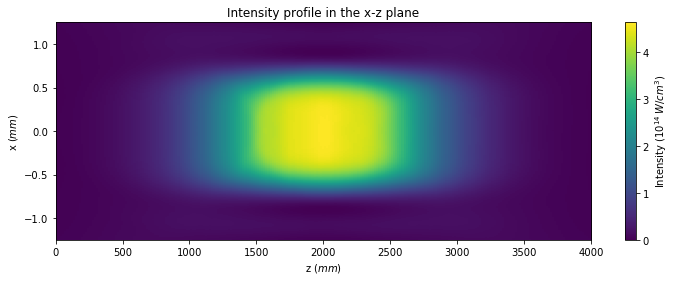

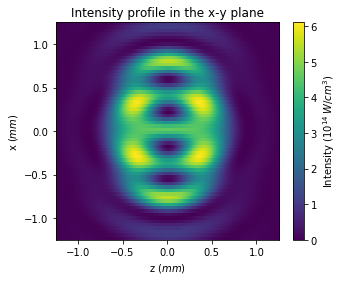

In [9]:
E4Order = np.load('/media/robert/Data_Storage/Data/Optics/nBessel/Fourth_Order_Bessel/electricField.npy')
E2Order = np.load('/media/robert/Data_Storage/Data/Optics/nBessel/Second_Order_Bessel/electricField.npy')
E0Order = np.load('/media/robert/Data_Storage/Data/Optics/nBessel/Zero_Order_Bessel/electricField.npy')
Etot = np.sqrt(4)*E4Order + np.sqrt(4)*E2Order + E0Order

X = params['X']
Y = params['Y']

plt.figure(figsize=(12,4))
plt.imshow(propagation.prep_data(Etot[:, :, int(Ny/2)]),
               aspect='auto',
               extent=[0, Z/1e3, -X/2e3, X/2e3])
cb = plt.colorbar()
cb.set_label(r'Intensity ($10^{14}\,W/cm^3$)')
plt.set_cmap('viridis')
plt.xlabel(r'z ($mm$)')
plt.ylabel(r'x ($mm$)')
plt.title('Intensity profile in the x-z plane')
plt.xlim([0, Z/1e3])
plt.ylim([-X/8e3, X/8e3])
plt.show()

plt.figure(figsize=(5,4))
plt.imshow(propagation.prep_data(Etot[int(Nz/2), :, :]),
               aspect='auto',
               extent=[-X/2e3, X/2e3, -Y/2e3, Y/2e3,])
cb = plt.colorbar()
cb.set_label(r'Intensity ($10^{14}\,W/cm^3$)')
plt.set_cmap('viridis')
plt.xlabel(r'z ($mm$)')
plt.ylabel(r'x ($mm$)')
plt.title('Intensity profile in the x-y plane')
plt.ylim([-Y/8e3, Y/8e3])
plt.xlim([-X/8e3, X/8e3])
plt.show()

del E4Order
del E2Order
del E0Order
del Etot